In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr

injury_data = pd.read_csv("../Resources/Confidential.csv")


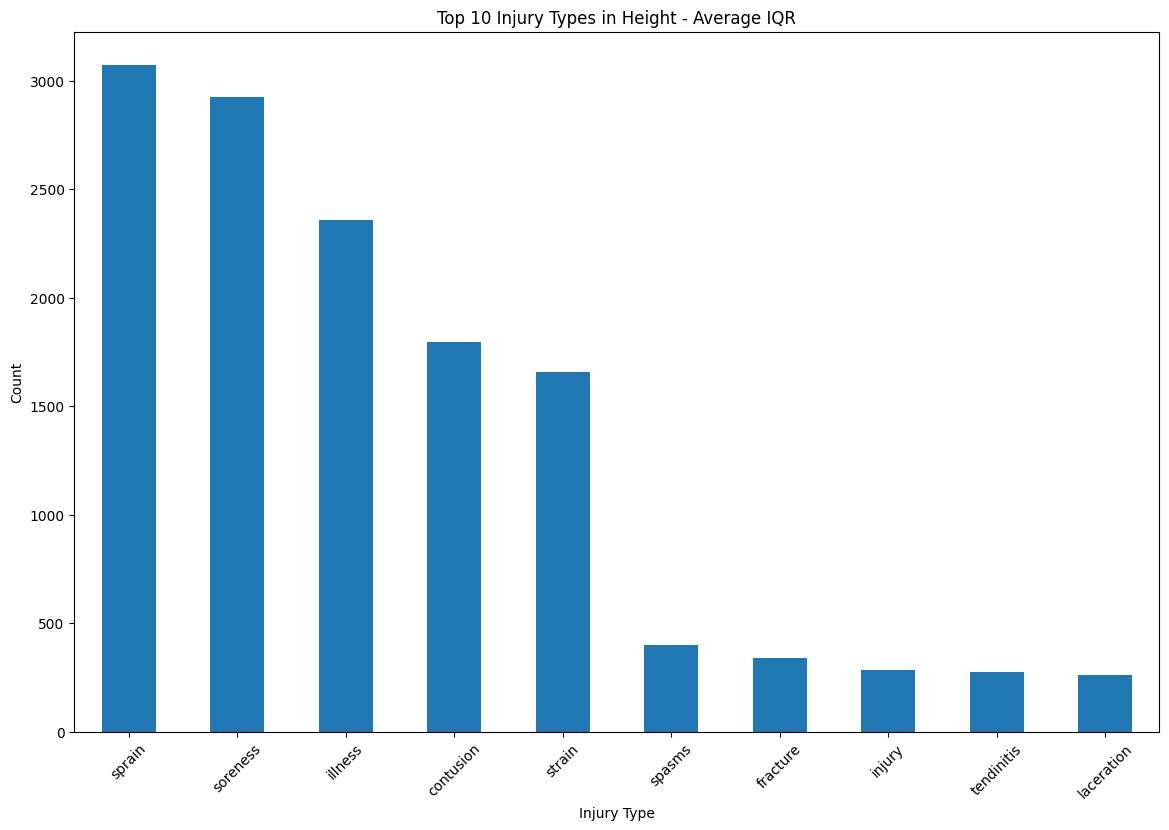

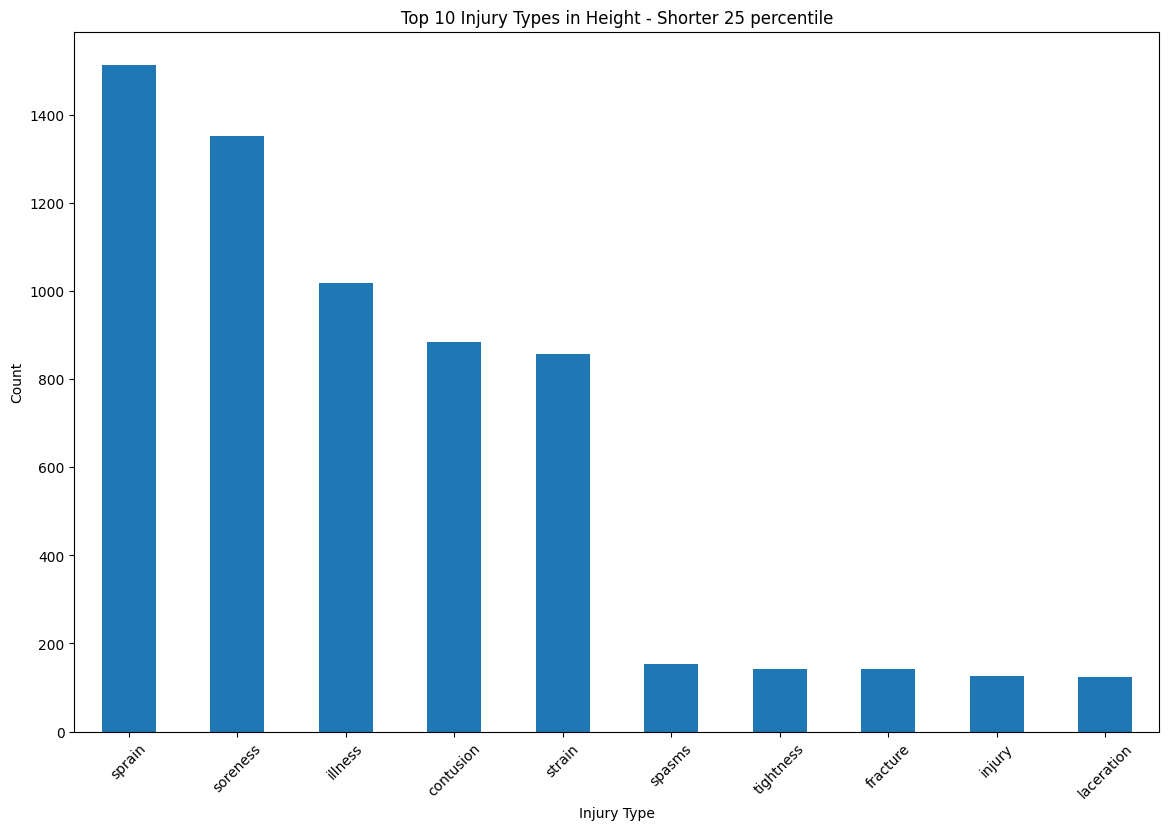

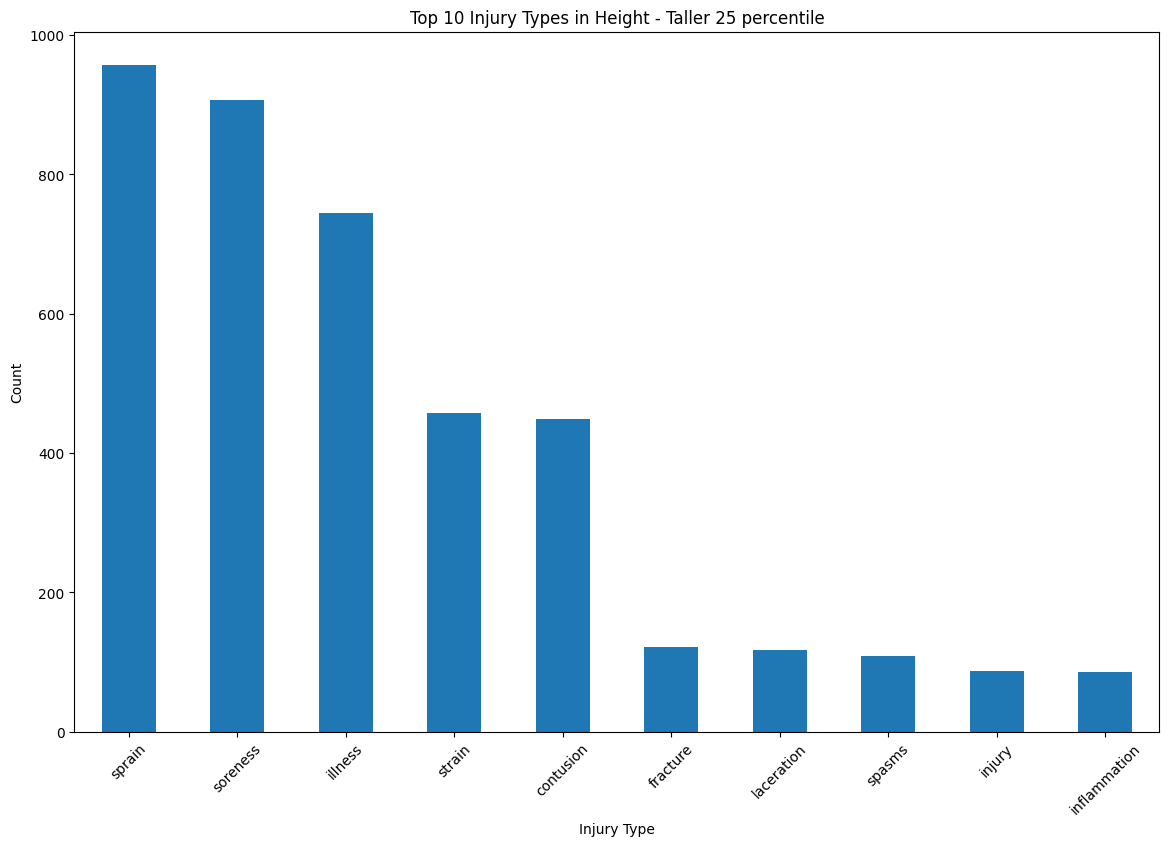

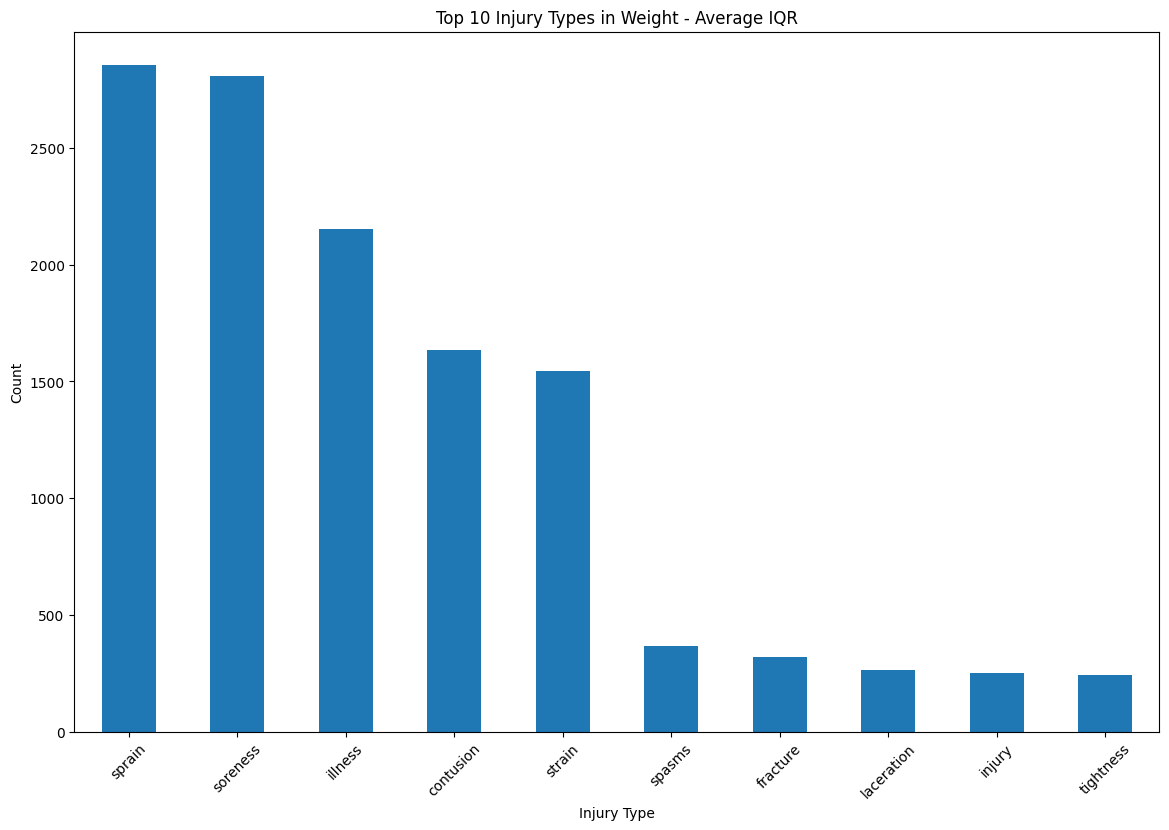

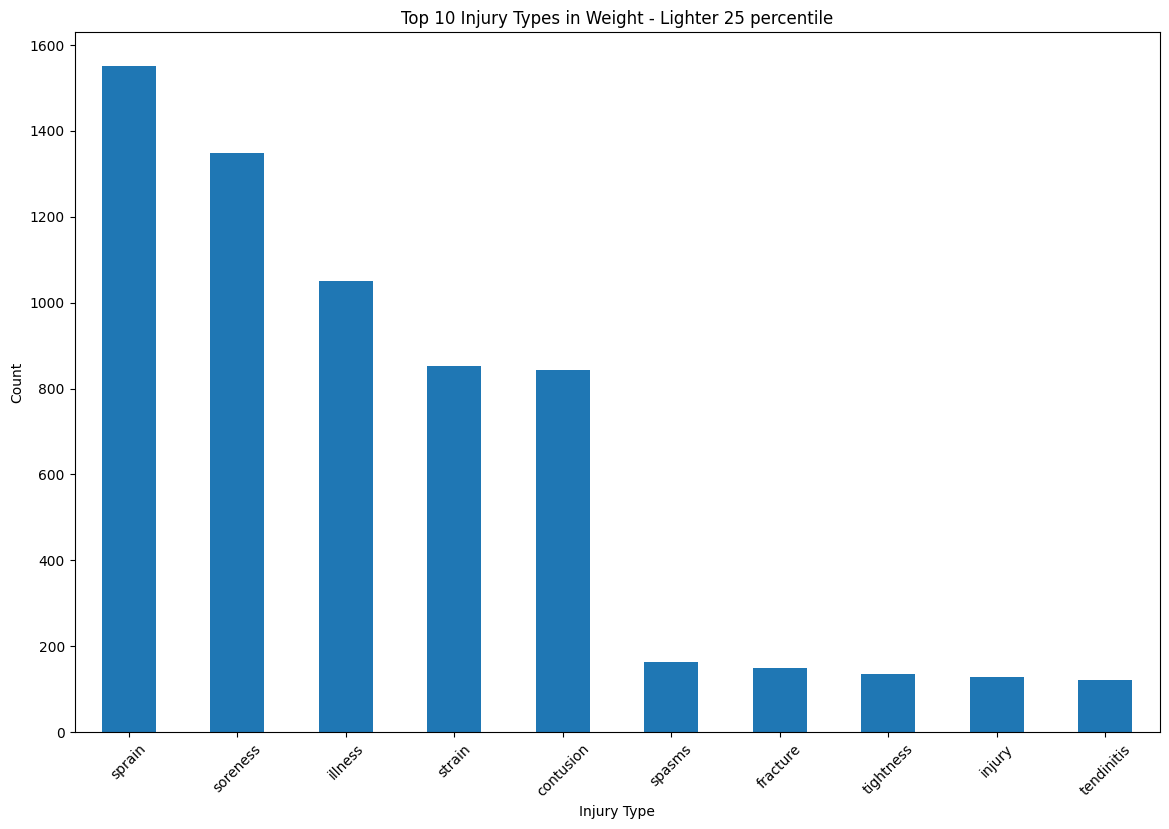

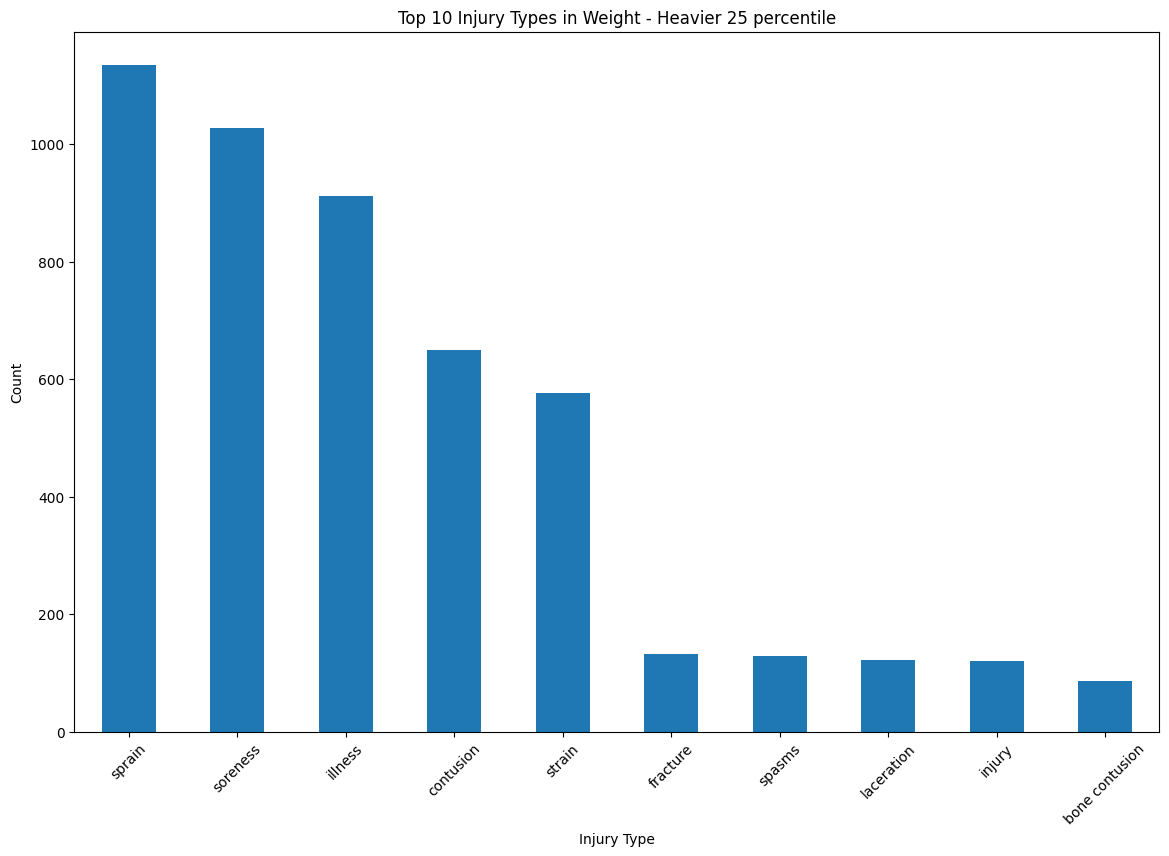

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to convert height from feet and inches to inches
def height_to_inches(height):
    if isinstance(height, str):  
        parts = height.split("'")
        feet = int(parts[0])  
        inches = int(parts[1].replace('"', '').strip())  
        return feet * 12 + inches
    else:
        return height  

# Convert 'Height' from feet and inches to inches by running through height_to_inches function
injury_data['Height'] = injury_data['Height'].apply(height_to_inches)

# Create a copy of the DataFrame 
filtered_injury_data = injury_data.copy()

# Calculate Q1 and Q3 for height
Q1_height = filtered_injury_data['Height'].quantile(0.25)
Q3_height = filtered_injury_data['Height'].quantile(0.75)

# Function to categorize height based on Q1 and Q3
def categorize_height(height):
    if height <= Q1_height:
        return 'Shorter 25 percentile'
    elif height <= Q3_height:
        return 'Average IQR'
    else:
        return 'Taller 25 percentile'

# Calculate Q1 and Q3 for weight
Q1_weight = filtered_injury_data['Weight'].quantile(0.25)
Q3_weight = filtered_injury_data['Weight'].quantile(0.75)

# Function to categorize weight based on Q1 and Q3
def categorize_weight(weight):
    if weight <= Q1_weight:
        return 'Lighter 25 percentile'
    elif weight <= Q3_weight:
        return 'Average IQR'
    else:
        return 'Heavier 25 percentile'

# Apply the categorization functions using .loc
filtered_injury_data.loc[:, 'Height Category'] = filtered_injury_data['Height'].apply(categorize_height)
filtered_injury_data.loc[:, 'Weight Category'] = filtered_injury_data['Weight'].apply(categorize_weight)


# Function to plot a bar chart for the top 10 injury types
def plot_top_10_bar_chart(data, category_column, title):
    # Determine the top 10 injury types for each category
    top_10_injuries = data.groupby([category_column, 'Injury Type']).size().groupby(level=0).nlargest(10).reset_index(level=0, drop=True)

    # Create a bar chart for each category
    categories = data[category_column].unique()
    for category in categories:
        subset = top_10_injuries.loc[category]
        subset.plot(kind='bar', figsize=(14, 10))
        plt.title(f"Top 10 Injury Types in {title} - {category}")
        plt.ylabel('Count')
        plt.xlabel('Injury Type')
        plt.xticks(rotation=45)
        plt.subplots_adjust(bottom=0.15, top=0.85)
        plt.savefig(f"../images/Top_10_Injury_Types_{category}.png", format='png')
        plt.show()

# Plot bar charts for height categories
plot_top_10_bar_chart(filtered_injury_data, 'Height Category', 'Height')

# Plot bar charts for weight categories
plot_top_10_bar_chart(filtered_injury_data, 'Weight Category', 'Weight')


In [3]:
# Find the most frequent injury type
most_common_injury = filtered_injury_data['Injury Type'].mode()[0]

# Create a binary variable for whether each record is the most common injury type
filtered_injury_data['CommonInjuryOccurrence'] = (filtered_injury_data['Injury Type'] == most_common_injury).astype(int)

# Calculate Pearson correlation coefficient for height
height_correlation, height_p_value = stats.pearsonr(filtered_injury_data['Height'], filtered_injury_data['CommonInjuryOccurrence'])

# Calculate Pearson correlation coefficient for weight
weight_correlation, weight_p_value = stats.pearsonr(filtered_injury_data['Weight'], filtered_injury_data['CommonInjuryOccurrence'])

print(f"Height Correlation: {height_correlation}, P-value: {height_p_value}")
print(f"Weight Correlation: {weight_correlation}, P-value: {weight_p_value}")

# Interpret the results
# For Height
if height_p_value < 0.05:
    print("The height correlation is statistically significant.")
else:
    print("The height correlation is not statistically significant.")

# For Weight
if weight_p_value < 0.05:
    print("The weight correlation is statistically significant.")
else:
    print("The weight correlation is not statistically significant.")

Height Correlation: -0.006474424477780217, P-value: 0.2824839953425677
Weight Correlation: -0.013927648570800474, P-value: 0.020773230014886172
The height correlation is not statistically significant.
The weight correlation is statistically significant.


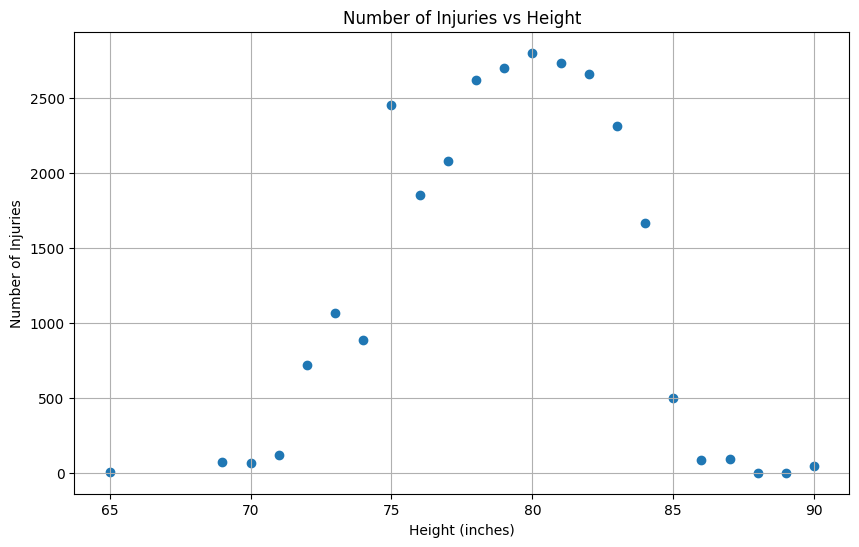

In [4]:
# Aggregate data to count the number of injuries for each height
injury_counts_by_height = filtered_injury_data.groupby('Height').size()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(injury_counts_by_height.index, injury_counts_by_height.values)
plt.title('Number of Injuries vs Height')
plt.xlabel('Height (inches)')
plt.ylabel('Number of Injuries')
plt.grid(True)

plt.savefig('../images/Number_of_Injuries_vs_Height.png', format='png')
plt.show()

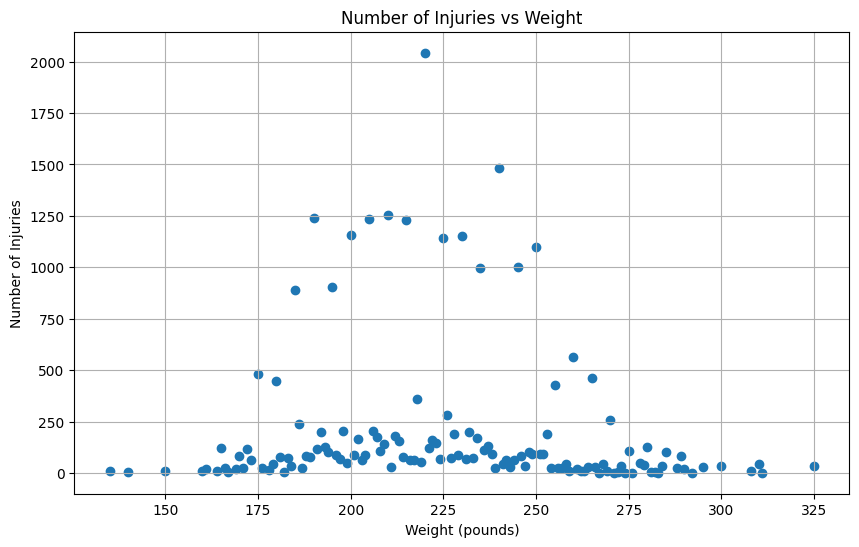

In [5]:
# Aggregate data to count the number of injuries for each weight
injury_counts_by_weight = filtered_injury_data.groupby('Weight').size()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(injury_counts_by_weight.index, injury_counts_by_weight.values)
plt.title('Number of Injuries vs Weight')
plt.xlabel('Weight (pounds)')
plt.ylabel('Number of Injuries')
plt.grid(True)
plt.savefig('../images/Number of Injuries vs Weight.png', format='png')
plt.show()

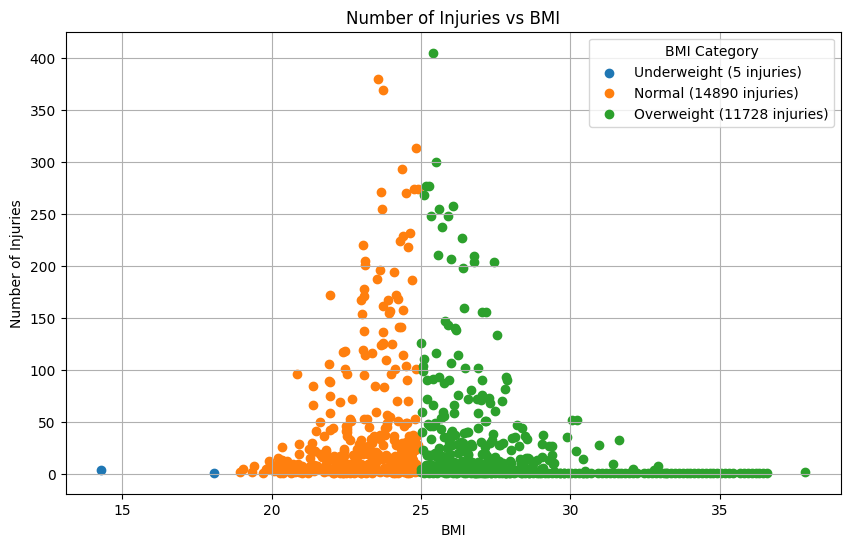

In [6]:
# Function to calculate BMI
def calculate_bmi(weight, height):
    return (weight / (height ** 2)) * 703

# Add a BMI column to the DataFrame
filtered_injury_data['BMI'] = filtered_injury_data.apply(lambda x: calculate_bmi(x['Weight'], x['Height']), axis=1)

# Define BMI categories
categories = {
    'Underweight': (0, 18.4), 
    'Normal': (18.5, 24.9), 
    'Overweight': (25.0, np.inf)
}

# Aggregate data to count the number of injuries for each BMI value
injury_counts_by_bmi = filtered_injury_data.groupby('BMI').size()

# Calculate the number of injuries in each category
category_injury_counts = {
    category: injury_counts_by_bmi[(injury_counts_by_bmi.index >= lower) & (injury_counts_by_bmi.index <= upper)].sum()
    for category, (lower, upper) in categories.items()
}

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot each category with different colors and include the count in the label
for category, (lower, upper) in categories.items():
    mask = (injury_counts_by_bmi.index >= lower) & (injury_counts_by_bmi.index <= upper)
    plt.scatter(injury_counts_by_bmi.index[mask], injury_counts_by_bmi.values[mask], label=f"{category} ({category_injury_counts[category]} injuries)")

plt.title('Number of Injuries vs BMI')
plt.xlabel('BMI')
plt.ylabel('Number of Injuries')
plt.legend(title='BMI Category')
plt.grid(True)
plt.savefig('../images/BMI_vs_Players.png', format='png')
plt.show()

In [7]:
# Count the number of injuries for each unique BMI value
bmi_injury_counts = filtered_injury_data.groupby('BMI').size()

# Create lists of BMI values and corresponding injury counts
bmi_values = bmi_injury_counts.index.tolist()
injury_counts = bmi_injury_counts.values.tolist()

# Calculate Pearson's correlation coefficient between BMI values and injury counts
correlation, p_value = pearsonr(bmi_values, injury_counts)

print(f"Pearson's correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson's correlation coefficient: -0.12343184187947362
P-value: 0.0008813348695541562


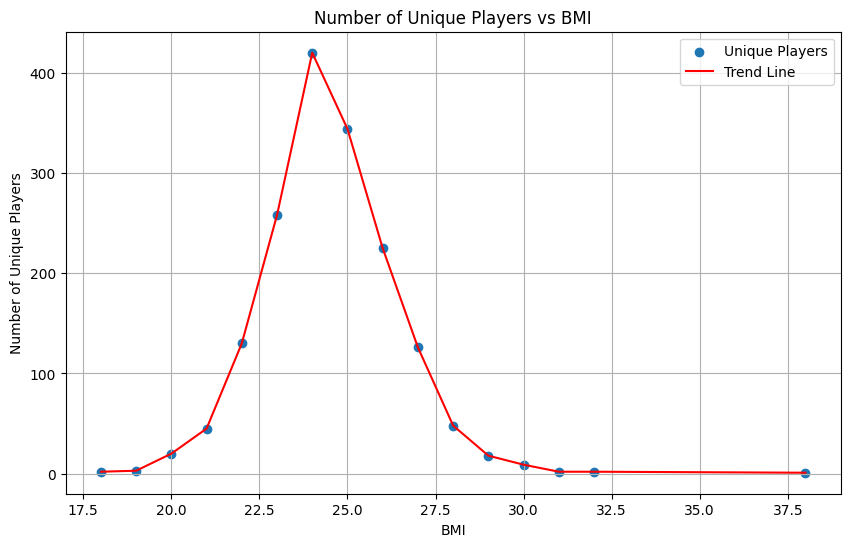

In [8]:

# Round the BMI values to reduce the spread for counting
filtered_injury_data['BMI_Rounded'] = filtered_injury_data['BMI'].round()

# Drop duplicate player entries to ensure each player is counted only once
unique_players_data = filtered_injury_data.drop_duplicates(subset='Playerid')

# Count the number of unique players for each BMI value
bmi_unique_player_counts = unique_players_data['BMI_Rounded'].value_counts().sort_index()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(bmi_unique_player_counts.index, bmi_unique_player_counts.values, label='Unique Players')

# Create a line plot on the same axes
plt.plot(bmi_unique_player_counts.index, bmi_unique_player_counts.values, color='red', label='Trend Line')

plt.title('Number of Unique Players vs BMI')
plt.xlabel('BMI')
plt.ylabel('Number of Unique Players')
plt.grid(True)
plt.legend()
plt.savefig('../images/Number of Unique Players vs BMI.png', format='png')
plt.show()

**Number of Injuries vs Height**
- This scatter plot shows that the number of injuries seems to be higher in players of a certain height range.
- There's a visible concentration of injuries among players between 70 to 80 inches tall, which is a typical height range for NBA players.
- Very tall players, those above 80 inches, appear to have fewer injuries, but this could be due to there being fewer players in that height range.

**Number of Injuries vs Weight:**
- The scatter plot suggests that the number of injuries is not strongly correlated with weight, as the data points are quite spread out.
- There is a cluster of injuries among players weighing between 200 to 250 pounds, which could be a common weight range for NBA players.

**Pearson correlation coefficient test I (Height/Weight vs Most Common Injury)**
The correlation for both height or weight with the most common injury(sprain) is very low and not statistically significant. This means that in this data set, there's no evidence to suggest that either a player's height or weight has a noticeable impact on the likelihood of sustaining the most common injury.

**Number of Unique Players vs BMI:**
- This line graph shows the number of unique players across different BMI values with a trend line.
- The trend line peaks at a BMI of around 24 to 25 and then sharply decreases. This could indicate that most NBA players fall within this BMI range.
- The sharp decline after the peak may suggest that there are fewer players with higher BMI, and this could correlate with the lower number of injuries in overweight players noted in the first graph.

**Pearson correlation coefficient test II (Number of Injuries vs BMI)**
The Pearson's correlation coefficient of -0.1234 indicates a very small negative linear relationship between BMI and the number of injuries, meaning that as BMI increases slightly, the number of injuries tends to decrease slightly. The p-value of 0.00088 is less than the standard threshold of 0.05, which suggests that the correlation is statistically significant. Despite the weakness of the correlation, it is unlikely to be due to random chance. 